# Monthly Mean Temp

### 1. Análisis exploratorio

En este paso se analiza la serie de tiempo correspondiente a la temperatura media mensual, comenzando en enero de 1920.

- La serie contiene datos mensuales en grados Fahrenheit.
- Se transformó la columna de fechas al tipo "datetime" para facilitar su análisis y visualización.
- A través de un gráfico de líneas se puede observar la variación estacional en las temperaturas, con subidas y bajadas que se repiten de forma cíclica cada año.

Este análisis inicial nos permite conocer la estructura del conjunto de datos, su rango temporal y los patrones generales.

Información del DataFrame:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1920-01-01 to 1939-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None

Primeras filas:

            Temperature
Month                  
1920-01-01         40.6
1920-02-01         40.8
1920-03-01         44.4
1920-04-01         46.7
1920-05-01         54.1

Estadísticas descriptivas:

       Temperature
count   240.000000
mean     49.041250
std       8.569705
min      31.300000
25%      41.550000
50%      47.350000
75%      57.000000
max      66.500000

Rango de fechas:
1920-01-01  →  1939-12-01


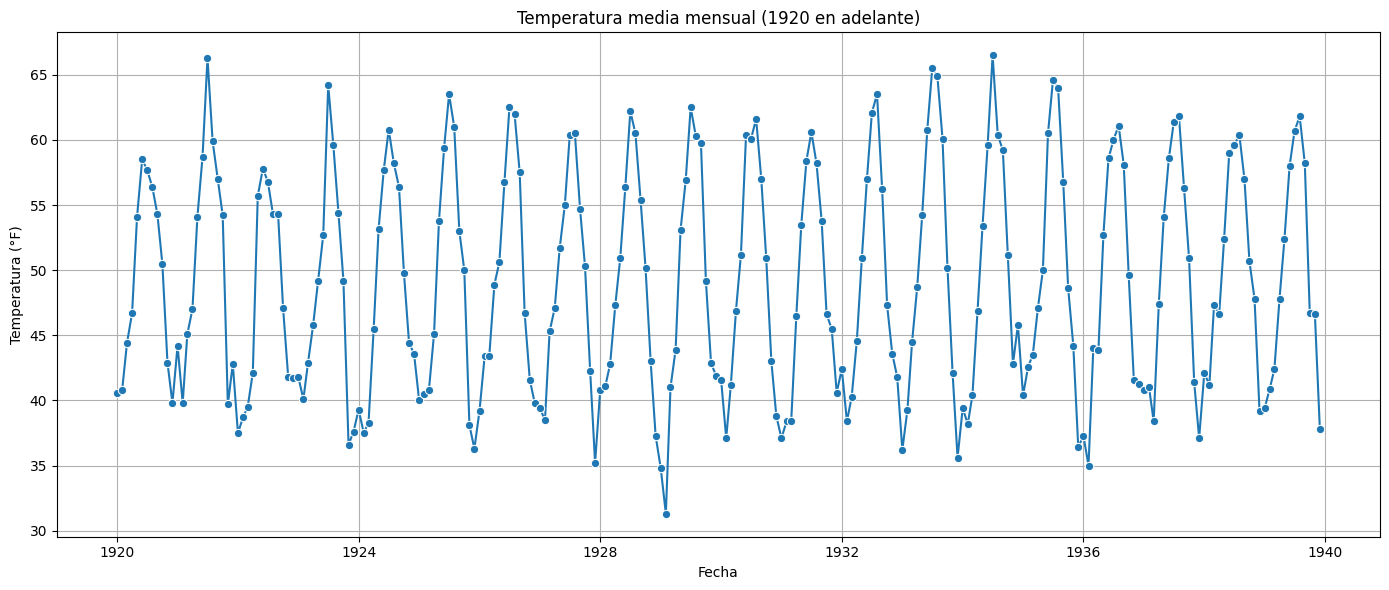

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("monthly-mean-temp.csv")
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

print("Información del DataFrame:\n")
print(df.info())
print("\nPrimeras filas:\n")
print(df.head())
print("\nEstadísticas descriptivas:\n")
print(df.describe())
print("\nRango de fechas:")
print(f"{df.index.min().date()}  →  {df.index.max().date()}")

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index, y='Temperature', marker='o')
plt.title("Temperatura media mensual (1920 en adelante)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. Promedios Móviles

Se aplicaron dos métodos de promedio móvil para suavizar la serie:

- Media Móvil de 6 meses: reduce la variación mensual y suaviza fluctuaciones de corto plazo.
- Media Móvil de 12 meses: proporciona una vista más general del comportamiento anual.

Ambas ayudan a identificar patrones estacionales y tendencias a largo plazo, eliminando parte del "ruido" en los datos originales. Como se observa en el gráfico, la media móvil de 12 meses es más suave y sigue de manera más estable la tendencia central.

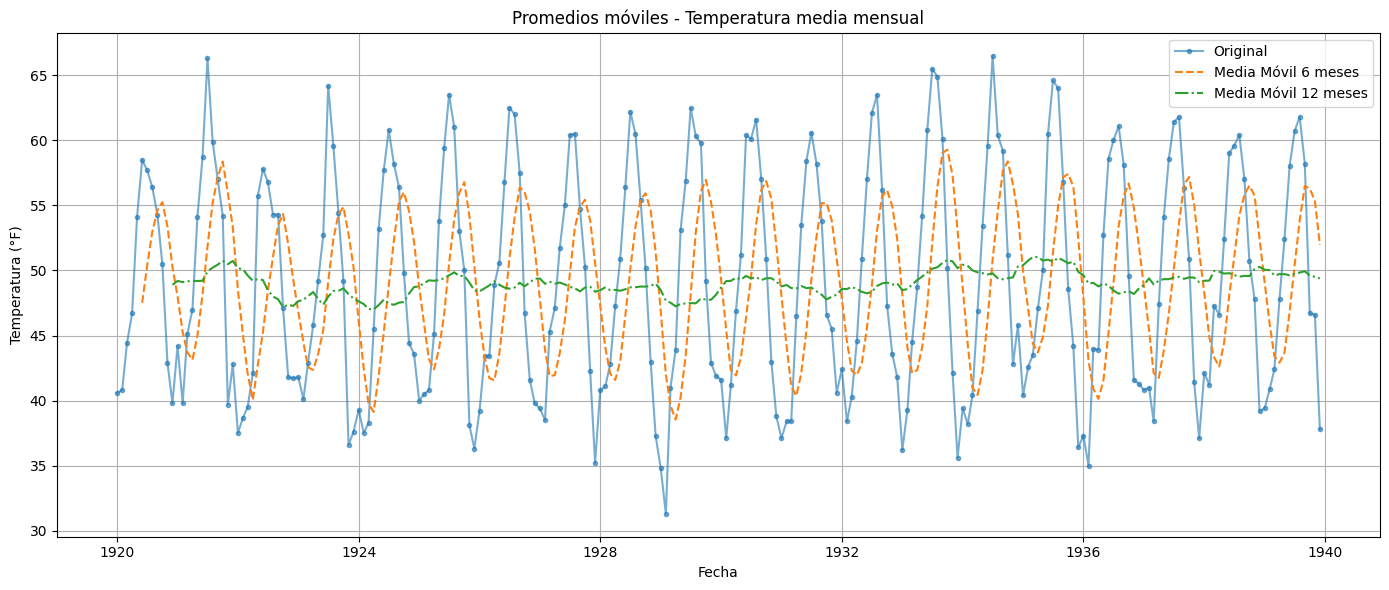

In [3]:
df['Media_Movil_6'] = df['Temperature'].rolling(window=6).mean()
df['Media_Movil_12'] = df['Temperature'].rolling(window=12).mean()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Temperature'], label='Original', marker='o', markersize=3, alpha=0.6)
plt.plot(df.index, df['Media_Movil_6'], label='Media Móvil 6 meses', linestyle='--')
plt.plot(df.index, df['Media_Movil_12'], label='Media Móvil 12 meses', linestyle='-.')
plt.title("Promedios móviles - Temperatura media mensual")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. Alisamiento exponencial

### 4. HOLT-WINTERS

### 5. SARIMA

### 6. Prophet

### 7. Comparación y Evaluación